This is a Policy Gradient implementation:
* Baseline for the advantage estimation is state value, given by the separately optimized value network.
* Entropy term added for improved exploration

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

import gymnasium as gym

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from model import Policy, Value

In [6]:
# env = gym.make("FrozenLake-v1", is_slippery=False)        # Discrete obs space
# env = gym.make("Taxi-v3")                                 # Discrete obs space
# env = gym.make("CliffWalking-v0")                         # Discrete obs space
env = gym.make("CartPole-v1")                               # Box obs space

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = Policy(env).to(device)
value = Value(env).to(device)
optimizer_p = torch.optim.Adam(policy.parameters(), lr=0.0003)
optimizer_v = torch.optim.Adam(value.parameters(), lr=0.0003)

gamma = 0.99
batch_size = 16     # For both value and policy update
rews_log = []
rews_ep = []

In [21]:
t = 0.001     # Temperature of the entropy term

loss_value = 0.0
loss_policy = 0.0

for episode in tqdm(range(1000)):    
    obs, _ = env.reset()
    done = False
    
    m_obs = []
    m_act = []
    m_rew = []
    
    # Play the game and collect data
    while not done:
        p = policy(torch.tensor(obs).to(device))
        action = p.sample().detach().item()
    
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
    
        m_obs.append(obs)
        m_act.append(action)
        m_rew.append(reward)

    rews_ep.append(sum(m_rew))
    m_obs = torch.tensor(m_obs, requires_grad=False).to(device)
    m_act = torch.tensor(m_act, requires_grad=False).to(device)
    m_rew = torch.tensor(m_rew, requires_grad=False).to(device)
    
    
    # Calculate the discounted rewards
    G = 0
    disc_rew = []
    for reward in reversed(m_rew):
        G = reward + gamma * G
        disc_rew.insert(0, G)
    
    # The gradient of the PG objective
    with torch.no_grad():
        A = torch.tensor(disc_rew).to(device) - value(m_obs)
        A = (A - A.mean()) / (A.std() + 1e-8)
    log_prob = policy(m_obs).log_prob(m_act)
    H = (log_prob * log_prob.exp()).sum()   # Entropy term
    loss_policy -= (A * log_prob).sum() + t * H
    
    # The gradient of the value fn
    target = m_rew[:-1] + gamma * value(m_obs[1:])
    actual = value(m_obs[:-1])
    last_loss = abs(value(m_obs[-1]) - m_rew[-1])   # terminal step
    
    # Normalize the values
    target = (target - target.mean()) / (target.std() + 1e-8)
    actual = (actual - actual.mean()) / (actual.std() + 1e-8)
    
    # if actual.shape != target.shape:      # needed for box obs spaces
    #     actual = actual.unsqueeze(0)
    loss_value += F.mse_loss(actual, target) + last_loss   

    # Optimization
    if episode % batch_size == 0 and episode != 0:   
        # Value network
        optimizer_v.zero_grad()
        loss_value.backward()
        optimizer_v.step()        
        
        # Policy Network
        optimizer_p.zero_grad()
        loss_policy.backward()
        optimizer_p.step()

        # Reset and log
        loss_value = 0.0
        loss_policy = 0.0
            
        rews_log.append(sum(rews_ep) / batch_size)
        rews_ep = []

100%|██████████| 1000/1000 [00:53<00:00, 18.67it/s]


500.0

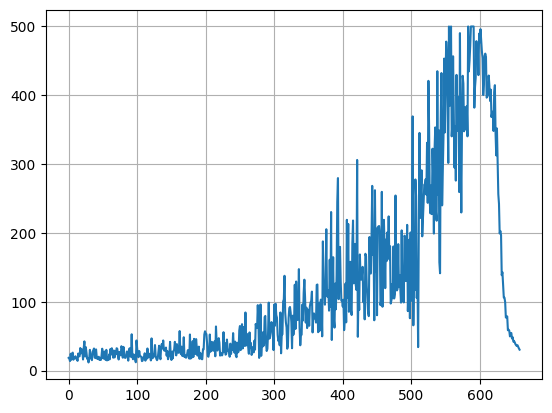

In [23]:
plt.plot(rews_log)
plt.grid()
max(rews_log)
# The learning crashes after reaching the optimal behavior,
# probably too high policy updates

In [13]:
# Visualization
import time
from IPython.display import display, clear_output

env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = env.reset()
done = False
steps = 0
while not done:
    steps += 1
    p = policy(torch.tensor(obs).to(device))
    action = p.sample().detach().item()

    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    ### Uncomment below for rendering (tested in ipynb)
    # a = env.render()
    # plt.imshow(a)
    # plt.axis('off')  # Turn off axis
    # display(plt.gcf())  # Display the current figure
    # clear_output(wait=True)  # Clear the previous output
print(steps)

RuntimeError: a Tensor with 4 elements cannot be converted to Scalar